* input : df_10.csv

* C'est un jeu de données avec un pre-processing de 10% des données initiales
* on utilise un pipeline pour équilibrer les classes des cibles
* modélisation
* calcul de la fonction de coût des modèles

# Introduction

## Problématique

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Données

* 10 fichiers CSV
* Vous aurez sûrement besoin de joindre les différentes tables entre elles.

## Votre mission

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

## Imports et paramétrage

In [1]:
#Importation des librairies utiles pour le projet :

#built in
import statistics
import os, sys, time, random
from collections import Counter

#data
import pandas as pd
import numpy as np

#stats
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#viz
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# modelisation
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import TruncatedSVD 
from sklearn import decomposition
#from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline 

# models

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cluster
import scipy.cluster.hierarchy as shc
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics.cluster import adjusted_rand_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
import sklearn.metrics
#from functions import *

import shap

C:\Users\ndergham\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option("display.max_rows", None)

In [3]:
#Importation des jeux de données utiles pour le projet :

df1 = pd.read_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/df_10.csv")
df1 = df1.sample(frac = 0.1)
df1 = df1.dropna()

# Comprendre la forme et la structure des données

## Jeux de données

On va regarder rapidement les informations contenues dans les différents jeux de données pour savoir lesquelles sont intéressantes 

In [4]:
df1.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Higher education.1,NAME_EDUCATION_TYPE_Incomplete higher
16900,0,0,135000.0,931500.0,27364.5,931500.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
26363,0,1,315000.0,291915.0,21955.5,252000.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2882,0,0,108000.0,808650.0,26217.0,675000.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
21462,0,0,94500.0,454500.0,21996.0,454500.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16616,0,1,450000.0,835380.0,42840.0,675000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [5]:
df1.shape

(3070, 16)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3070 entries, 16900 to 2713
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   TARGET                                  3070 non-null   int64  
 1   CNT_CHILDREN                            3070 non-null   int64  
 2   AMT_INCOME_TOTAL                        3070 non-null   float64
 3   AMT_CREDIT                              3070 non-null   float64
 4   AMT_ANNUITY                             3070 non-null   float64
 5   AMT_GOODS_PRICE                         3070 non-null   float64
 6   NAME_CONTRACT_TYPE_Cash loans           3070 non-null   float64
 7   NAME_CONTRACT_TYPE_Revolving loans      3070 non-null   float64
 8   FLAG_OWN_CAR_No                         3070 non-null   float64
 9   FLAG_OWN_CAR_Yes                        3070 non-null   float64
 10  FLAG_OWN_REALTY_No                      3070 non-null   

In [7]:
df1.dtypes

TARGET                                      int64
CNT_CHILDREN                                int64
AMT_INCOME_TOTAL                          float64
AMT_CREDIT                                float64
AMT_ANNUITY                               float64
AMT_GOODS_PRICE                           float64
NAME_CONTRACT_TYPE_Cash loans             float64
NAME_CONTRACT_TYPE_Revolving loans        float64
FLAG_OWN_CAR_No                           float64
FLAG_OWN_CAR_Yes                          float64
FLAG_OWN_REALTY_No                        float64
FLAG_OWN_REALTY_Yes                       float64
NAME_EDUCATION_TYPE_Academic degree       float64
NAME_EDUCATION_TYPE_Higher education      float64
NAME_EDUCATION_TYPE_Higher education.1    float64
NAME_EDUCATION_TYPE_Incomplete higher     float64
dtype: object

In [8]:
df1.dtypes.value_counts()

float64    14
int64       2
dtype: int64

# Modélisation

## Définition cible et variables

In [9]:
y = df1.TARGET

In [10]:
y.value_counts(normalize = True)

0    0.925081
1    0.074919
Name: TARGET, dtype: float64

In [11]:
cols = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_CONTRACT_TYPE_Cash loans",
        "NAME_CONTRACT_TYPE_Revolving loans", "FLAG_OWN_CAR_No", "FLAG_OWN_CAR_Yes", "FLAG_OWN_REALTY_No", "FLAG_OWN_REALTY_Yes",
        "NAME_EDUCATION_TYPE_Academic degree", "NAME_EDUCATION_TYPE_Higher education", 
        "NAME_EDUCATION_TYPE_Incomplete higher",]
X = df1[cols]
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher
16900,0,135000.0,931500.0,27364.5,931500.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
26363,1,315000.0,291915.0,21955.5,252000.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2882,0,108000.0,808650.0,26217.0,675000.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
21462,0,94500.0,454500.0,21996.0,454500.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
16616,1,450000.0,835380.0,42840.0,675000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


# Modélisation

On va implémenter plusieurs modèles de classification et comparer leur performance pour connaitre la meilleur configuration.

En plus des différents modèles, on va comparer :

- l'usage ou non d'un standard scaler
- l'usage ou non d'un reducteur dimensionnel (PCA, LDA, TruncatedSVD)

On créé un fonction pour afficher les résultats de la grid search triés par **mean_test_score** du plus grand au plus petit.

Le **mean_test_score** est la moyenne des score de test des modèles prédictifs entrainés et testé sur chaque "fold" de la validation croisée.

In [12]:
def resultize(grid, model = "", data ="") : 
    """ """
    
    res = pd.DataFrame(grid.cv_results_)
    res["model"] = model
    cols = [i for i in res.columns if "split" not in i  ]
    
    res
    
    
    return res[cols].sort_values("rank_test_score", ascending=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Grid search

In [14]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [DummyClassifier()],
    
}

## Pipeline avec IMB learn

In [15]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', DummyClassifier())
])


## DummyClassifier

In [16]:
dummy = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
dummy.fit(X_train, y_train)
res = resultize(dummy, model = "dummy")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,0.018051,0.012416,0.004069,0.005927,DummyClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': DummyClassifier(), 'sampler': Ra...",0.5,0.0,1,dummy
1,0.013734,0.018883,0.003125,0.006250,DummyClassifier(),RandomUnderSampler(),passthrough,"{'estimator': DummyClassifier(), 'sampler': Ra...",0.5,0.0,1,dummy
2,0.007869,0.005949,0.007733,0.006622,DummyClassifier(),passthrough,StandardScaler(),"{'estimator': DummyClassifier(), 'sampler': 'p...",0.5,0.0,1,dummy
3,0.000568,0.000747,0.001593,0.002970,DummyClassifier(),passthrough,passthrough,"{'estimator': DummyClassifier(), 'sampler': 'p...",0.5,0.0,1,dummy


### Indicateurs

In [17]:
y_pred_dummy = dummy.predict(X_test)

In [18]:
a0 = confusion_matrix(y_test, y_pred_dummy)
a0

array([[561,   0],
       [ 53,   0]], dtype=int64)

In [19]:
b0 = accuracy_score(y_test, y_pred_dummy)
b0

0.9136807817589576

In [20]:
c0 = f1_score(y_test, y_pred_dummy)
c0

0.0

In [21]:
d0 = recall_score(y_test, y_pred_dummy)
d0

0.0

In [22]:
e0 = precision_score(y_test, y_pred_dummy)
e0

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


0.0

In [23]:
f0 = roc_auc_score(y_test, y_pred_dummy)
f0

0.5

## Random Forest

In [24]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500)],
    
}


In [25]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500))
])

In [26]:
R_F = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_F.fit(X_train, y_train)
res = resultize(R_F, model = "Random Forest")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
1,1.278357,0.059814,0.110817,0.005367,"RandomForestClassifier(max_depth=20, min_sampl...",RandomUnderSampler(),passthrough,{'estimator': RandomForestClassifier(max_depth...,0.564072,0.054570,1,Random Forest
0,1.368910,0.139424,0.111217,0.005966,"RandomForestClassifier(max_depth=20, min_sampl...",RandomUnderSampler(),StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.543218,0.063151,2,Random Forest
3,2.493433,0.148585,0.121713,0.034020,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,passthrough,{'estimator': RandomForestClassifier(max_depth...,0.533046,0.055387,3,Random Forest
2,2.207798,0.091145,0.124459,0.032006,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.525574,0.051064,4,Random Forest


In [27]:
y_pred_rf = R_F.predict(X_test)

In [28]:
a1 = confusion_matrix(y_test, y_pred_rf)
a1

array([[303, 258],
       [ 21,  32]], dtype=int64)

In [29]:
b1 = accuracy_score(y_test, y_pred_rf)
b1

0.5456026058631922

In [30]:
c1 = f1_score(y_test, y_pred_rf)
c1

0.18658892128279886

In [31]:
d1 = recall_score(y_test, y_pred_rf)
d1

0.6037735849056604

In [32]:
e1 = precision_score(y_test, y_pred_rf)
e1

0.1103448275862069

In [33]:
f1 = roc_auc_score(y_test, y_pred_rf)
f1

0.571940268388659

## K-NN

In [34]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [neighbors.KNeighborsClassifier(n_neighbors=3)],
    
}


In [35]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', neighbors.KNeighborsClassifier(n_neighbors=3))
])

In [36]:
K_NN = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
K_NN.fit(X_train, y_train)
res = resultize(K_NN, model = "K-NN")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,0.014296,0.001097,0.007400,0.000491,KNeighborsClassifier(n_neighbors=3),RandomUnderSampler(),StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.502791,0.052639,1,K-NN
1,0.013899,0.002428,0.010914,0.012229,KNeighborsClassifier(n_neighbors=3),RandomUnderSampler(),passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.497059,0.051945,2,K-NN
3,0.018332,0.001730,0.005435,0.002559,KNeighborsClassifier(n_neighbors=3),passthrough,passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.496935,0.025851,3,K-NN
2,0.022450,0.008020,0.023001,0.004959,KNeighborsClassifier(n_neighbors=3),passthrough,StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.488030,0.033798,4,K-NN


In [37]:
y_pred_knn = K_NN.predict(X_test)

In [38]:
a2 = confusion_matrix(y_test, y_pred_knn)
a2

array([[268, 293],
       [ 20,  33]], dtype=int64)

In [39]:
b2 = accuracy_score(y_test, y_pred_knn)
b2

0.49022801302931596

In [40]:
c2 = f1_score(y_test, y_pred_knn)
c2

0.1741424802110818

In [41]:
d2 =recall_score(y_test, y_pred_knn)
d2

0.6226415094339622

In [42]:
e2 = precision_score(y_test, y_pred_knn)
e2

0.10122699386503067

In [43]:
f2 = roc_auc_score(y_test, y_pred_knn)
f2

0.5501799347526317

## regression logistique

In [44]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [LogisticRegression()],
    
}

In [45]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', LogisticRegression())
])

In [46]:
R_L = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_L.fit(X_train, y_train)
res = resultize(R_L, model = "Regression logistique")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
2,0.024034,0.004407,0.007954,0.004902,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.588698,0.049712,1,Regression logistique
0,0.031000,0.003376,0.005600,0.002836,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.575922,0.049479,2,Regression logistique
1,0.025777,0.006060,0.007478,0.006405,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.560672,0.043626,3,Regression logistique
3,0.022377,0.004009,0.004900,0.001301,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.550854,0.067008,4,Regression logistique


In [47]:
y_pred_rl = R_L.predict(X_test)

In [48]:
a3 = confusion_matrix(y_test, y_pred_rl)
a3

array([[561,   0],
       [ 53,   0]], dtype=int64)

In [49]:
b3 = accuracy_score(y_test, y_pred_rl)
b3

0.9136807817589576

In [50]:
c3 = f1_score(y_test, y_pred_rl)
c3

0.0

In [51]:
d3 = recall_score(y_test, y_pred_rl)
d3

0.0

In [52]:
e3 = precision_score(y_test, y_pred_rl)
e3

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


0.0

In [53]:
f3 = roc_auc_score(y_test, y_pred_rl)
f3

0.5

## XG Boost

In [54]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [xgb.XGBClassifier()],
    
}


In [55]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', xgb.XGBClassifier())
])

In [56]:
X_G_IMBL = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
X_G_IMBL.fit(X_train, y_train)
res = resultize(X_G_IMBL, model = "XGBOOST")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[10:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
1,0.729749,0.039201,0.009834,0.007584,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.570625,0.077751,1,XGBOOST
2,0.928136,0.069568,0.007812,0.007812,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.539367,0.057249,2,XGBOOST
3,0.907145,0.045882,0.012138,0.008189,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.539316,0.057187,3,XGBOOST
0,0.757552,0.083669,0.012301,0.003288,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(),StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.520117,0.057908,4,XGBOOST


In [57]:
y_pred_xg = X_G_IMBL.predict(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [58]:
a4 = confusion_matrix(y_test, y_pred_xg)
a4

array([[290, 271],
       [ 19,  34]], dtype=int64)

In [59]:
b4 = accuracy_score(y_test, y_pred_xg)

In [60]:
c4 =f1_score(y_test, y_pred_xg)
c4

0.18994413407821228

In [61]:
d4 = recall_score(y_test, y_pred_xg)
d4

0.6415094339622641

In [62]:
e4 = precision_score(y_test, y_pred_xg)
e4

0.11147540983606558

In [63]:
f4 = roc_auc_score(y_test, y_pred_xg)
f4

0.5792217401540375

# Récapitulatif et conclusions

In [64]:
resultats = pd.DataFrame({
                        'Dummy': [a0, b0, c0, d0, e0, f0], 
                          'Random Forest': [a1, b1, c1, d1, e1, f1],
                         'K-NN': [a2, b2, c2, d2, e2, f2],
                         'Logistic regression': [a3, b3, c3, d3, e3, f3],
                        'XG-Boost': [a4, b4, c4, d4, e4, f4]},
                         index = ['Matrice de confusion', 'Accuracy', "F1", "Recall", "Precision", "ROC AUC"])

In [65]:
resultats

,Dummy,Random Forest,K-NN,Logistic regression,XG-Boost
Matrice de confusion,"[[561, 0], [53, 0]]","[[303, 258], [21, 32]]","[[268, 293], [20, 33]]","[[561, 0], [53, 0]]","[[290, 271], [19, 34]]"
Accuracy,0.913681,0.545603,0.490228,0.913681,0.527687
F1,0.0,0.186589,0.174142,0.0,0.189944
Recall,0.0,0.603774,0.622642,0.0,0.641509
Precision,0.0,0.110345,0.101227,0.0,0.111475
ROC AUC,0.5,0.57194,0.55018,0.5,0.579222


# Fonction de décision

In [66]:
def fonction_decision (X):
    
    # extract amount credit
    #X["profit"] = X["AMT_CREDIT"] * rate
    
    
    # compute profit and lost 
   
    if X["pred"] == 1 :
         return 0
    elif X["y_true"] == 0 and X["pred"] == 0:
         return X["profit"]

    return -X["AMT_CREDIT"] * 0.5

## DummyClasifier

In [67]:
X_dummy = pd.DataFrame(y_pred_dummy, columns = ["pred"])

In [68]:
X_dummy["y_true"] = y_test.reset_index(drop = True)

In [69]:
X_dummy["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [70]:
X_dummy["profit"] = X["AMT_CREDIT"] * 0.04
X_dummy.head()

,pred,y_true,AMT_CREDIT,profit
0,0,0,1078200.0,NaN
1,0,0,604152.0,NaN
2,0,0,755190.0,23085.9
3,0,0,225000.0,NaN
4,0,0,518562.0,NaN


In [71]:
PNL = []

for i in X_dummy.index :
    result = fonction_decision(X_dummy.loc[i])
    PNL.append(result)

In [72]:
PNL

[nan,
 nan,
 23085.9,
 nan,
 nan,
 nan,
 -260640.0,
 nan,
 nan,
 9000.0,
 -225000.0,
 nan,
 nan,
 -212127.75,
 -151038.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 -252821.25,
 nan,
 nan,
 -225000.0,
 nan,
 20057.4,
 nan,
 -566874.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -85320.0,
 -101250.0,
 nan,
 nan,
 nan,
 nan,
 31267.8,
 -512145.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -188460.0,
 nan,
 nan,
 nan,
 33424.2,
 nan,
 -249630.75,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -498667.5,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -377370.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -330234.75,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -290250.0,
 -286704.0,
 nan,
 nan,
 30207.600000000002,
 31276.8,
 nan,
 nan,
 nan,
 nan,
 nan,
 -58581.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 36000.0,
 -225000.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 9000.0,
 nan,
 nan,

In [73]:
cout_dummy = sum(PNL)
cout_dummy

nan

## Random Forest

In [74]:
X_rf = pd.DataFrame(y_pred_rf, columns = ["pred"])

In [75]:
X_rf["y_true"] = y_test.reset_index(drop = True)

In [76]:
X_rf["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [77]:
X_rf["profit"] = X["AMT_CREDIT"] * 0.04
X_rf.head()

,pred,y_true,AMT_CREDIT,profit
0,1,0,1078200.0,NaN
1,1,0,604152.0,NaN
2,0,0,755190.0,23085.9
3,0,0,225000.0,NaN
4,1,0,518562.0,NaN


In [78]:
PNL = []

for i in X_rf.index :
    result = fonction_decision(X_rf.loc[i])
    PNL.append(result)

In [79]:
PNL

[0,
 0,
 23085.9,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 nan,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 -566874.0,
 nan,
 nan,
 nan,
 nan,
 0,
 nan,
 -85320.0,
 -101250.0,
 0,
 0,
 0,
 nan,
 31267.8,
 -512145.0,
 nan,
 nan,
 nan,
 0,
 nan,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 -377370.0,
 nan,
 nan,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 0,
 0,
 30207.600000000002,
 31276.8,
 nan,
 nan,
 nan,
 0,
 0,
 -58581.0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 36000.0,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 0,
 0,
 0,
 0,
 nan,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 19153.44,
 0,
 nan,
 0,
 nan,
 nan,
 nan,
 nan,
 nan,
 0,
 13516.92,
 0,
 nan,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 0,
 nan,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 21368.16,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,


In [80]:
cout_RF = sum(PNL)
cout_RF

nan

In [81]:
## K-NN

In [82]:
X_knn = pd.DataFrame(y_pred_knn, columns = ["pred"])

In [83]:
X_knn["y_true"] = y_test.reset_index(drop = True)

In [84]:
X_knn["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [85]:
X_knn["profit"] = X["AMT_CREDIT"] * 0.04
X_knn.head()

,pred,y_true,AMT_CREDIT,profit
0,1,0,1078200.0,NaN
1,1,0,604152.0,NaN
2,0,0,755190.0,23085.9
3,1,0,225000.0,NaN
4,1,0,518562.0,NaN


In [86]:
PNL = []

for i in X_knn.index :
    result = fonction_decision(X_knn.loc[i])
    PNL.append(result)

In [87]:
PNL

[0,
 0,
 23085.9,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 -212127.75,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 nan,
 -225000.0,
 0,
 0,
 0,
 -566874.0,
 nan,
 0,
 nan,
 nan,
 0,
 nan,
 0,
 -101250.0,
 0,
 nan,
 0,
 nan,
 0,
 -512145.0,
 nan,
 nan,
 nan,
 0,
 nan,
 nan,
 -188460.0,
 0,
 0,
 0,
 33424.2,
 0,
 0,
 0,
 0,
 nan,
 nan,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 0,
 0,
 -498667.5,
 0,
 nan,
 0,
 0,
 0,
 nan,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 -58581.0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 36000.0,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 9000.0,
 nan,
 0,
 nan,
 nan,
 nan,
 19153.44,
 0,
 0,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 0,
 nan,
 nan,
 0,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 -

In [88]:
cout_knn = sum(PNL)
cout_knn

nan

## Regression Logistique

In [89]:
X_rl = pd.DataFrame(y_pred_rl, columns = ["pred"])

In [90]:
X_rl["y_true"] = y_test.reset_index(drop = True)

In [91]:
X_rl["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [92]:
X_rl["profit"] = X["AMT_CREDIT"] * 0.04
X_rl.head()

,pred,y_true,AMT_CREDIT,profit
0,0,0,1078200.0,NaN
1,0,0,604152.0,NaN
2,0,0,755190.0,23085.9
3,0,0,225000.0,NaN
4,0,0,518562.0,NaN


In [93]:
PNL = []

for i in X_rl.index :
    result = fonction_decision(X_rl.loc[i])
    PNL.append(result)

In [94]:
PNL

[nan,
 nan,
 23085.9,
 nan,
 nan,
 nan,
 -260640.0,
 nan,
 nan,
 9000.0,
 -225000.0,
 nan,
 nan,
 -212127.75,
 -151038.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 -252821.25,
 nan,
 nan,
 -225000.0,
 nan,
 20057.4,
 nan,
 -566874.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -85320.0,
 -101250.0,
 nan,
 nan,
 nan,
 nan,
 31267.8,
 -512145.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -188460.0,
 nan,
 nan,
 nan,
 33424.2,
 nan,
 -249630.75,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -498667.5,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -377370.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -330234.75,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -290250.0,
 -286704.0,
 nan,
 nan,
 30207.600000000002,
 31276.8,
 nan,
 nan,
 nan,
 nan,
 nan,
 -58581.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 36000.0,
 -225000.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 9000.0,
 nan,
 nan,

In [95]:
cout_rl = sum(PNL)
cout_rl

nan

In [96]:
## XG

In [97]:
X_fonction = pd.DataFrame(y_pred_xg, columns = ["pred"])

In [98]:
X_fonction["y_true"] = y_test.reset_index(drop = True)

In [99]:
X_fonction["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [100]:
X_fonction["profit"] = X["AMT_CREDIT"] * 0.04
X_fonction.head()

,pred,y_true,AMT_CREDIT,profit
0,1,0,1078200.0,NaN
1,1,0,604152.0,NaN
2,0,0,755190.0,23085.9
3,1,0,225000.0,NaN
4,0,0,518562.0,NaN


In [101]:
PNL = []

for i in X_fonction.index :
    result = fonction_decision(X_fonction.loc[i])
    PNL.append(result)

In [102]:
PNL

[0,
 0,
 23085.9,
 0,
 nan,
 nan,
 -260640.0,
 0,
 nan,
 9000.0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 -566874.0,
 0,
 nan,
 0,
 0,
 0,
 nan,
 -85320.0,
 -101250.0,
 0,
 nan,
 0,
 nan,
 31267.8,
 -512145.0,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 nan,
 0,
 33424.2,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 0,
 0,
 nan,
 -377370.0,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 30207.600000000002,
 0,
 nan,
 nan,
 0,
 0,
 0,
 -58581.0,
 nan,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 nan,
 nan,
 nan,
 36000.0,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 0,
 nan,
 0,
 0,
 0,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 nan,
 nan,
 nan,
 nan,
 nan,
 21368.16,
 nan,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,

In [103]:
cout_xg = sum(PNL)
cout_xg

nan

# Récapitulatif des coûts des modèles


In [104]:
resultats_modeles = pd.DataFrame({
                        'Dummy': [cout_dummy], 
                          'Random Forest': [cout_RF],
                         'K-NN': [cout_knn],
                         'Logistic regression': [cout_rl],
                        'XG-Boost': [cout_xg]},
                         index = ["Profit"])
resultats_modeles

,Dummy,Random Forest,K-NN,Logistic regression,XG-Boost
Profit,NaN,NaN,NaN,NaN,NaN


In [105]:
import pickle

In [106]:
with open("X_G_IMBL.pk","wb") as f:
    pickle.dump(X_G_IMBL, f)

In [107]:
X_G_IMBL

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampler', 'passthrough'),
                                       ('scaler', 'passthrough'),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None)],
                         'sampler': [RandomUnderSampler(), 'passthrough'],
                         'scaler': [StandardScaler(), 'passthrough']},
             scoring='roc_auc', verbose=3)

In [108]:
with open("X_G_IMBL.pk","rb") as f:
    model = pickle.load(f)

In [109]:
model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampler', 'passthrough'),
                                       ('scaler', 'passthrough'),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None)],
                         'sampler': [RandomUnderSampler(), 'passthrough'],
                         'scaler': [StandardScaler(), 'passthrough']},
             scoring='roc_auc', verbose=3)

# Feature importance et Shap

In [110]:
from xgboost import XGBClassifier
XGB = XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
XGB.fit(X_test, y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[10:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
with open("XGB.pk","wb") as f:
    pickle.dump(XGB, f)

XGB

with open("XGB.pk","rb") as f:
    model2 = pickle.load(f)

model2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
preds = XGB.predict(X_test)

In [113]:
## Feature importance

In [114]:
XGB.feature_importances_

array([0.        , 0.23012085, 0.12002626, 0.29811707, 0.16096947,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.12753676, 0.06322956], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

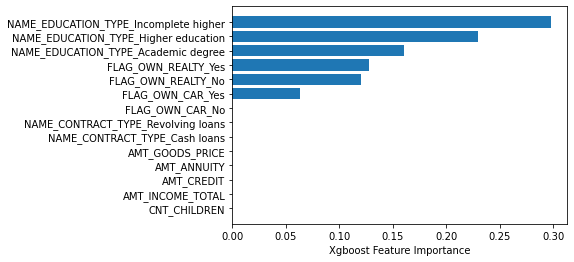

In [115]:
sorted_idx = XGB.feature_importances_.argsort()


plt.barh(cols, XGB.feature_importances_[sorted_idx])

plt.xlabel("Xgboost Feature Importance")

## Shap

In [116]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


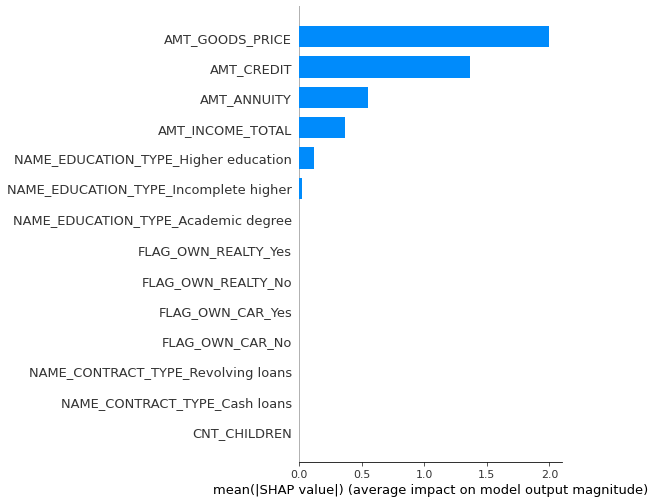

In [117]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

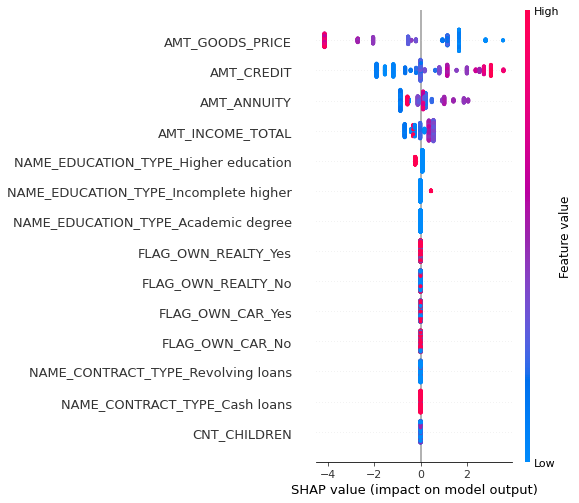

In [118]:
shap.summary_plot(shap_values, X_test)

In [119]:
row_to_show = 5

data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

XGB.predict_proba(data_for_prediction_array)

array([[0.9894834 , 0.01051656]], dtype=float32)

In [120]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(XGB.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using 2456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the pre